In [1]:
#| default_exp models.nhits

In [2]:
#| hide
%load_ext autoreload
%autoreload 2

In [3]:
# Initial
DATASET_NAME = 'BIDV'
DATASET_LABEL = 'BIDV'
TEST_RATIO = 0.2
TRAIN_TEST_LABEL = f'{(1 - TEST_RATIO) * 10:.0f}-{TEST_RATIO * 10:.0f}'

DAY_TO_PREDICT = 90

# NHITS

Long-horizon forecasting is challenging because of the *volatility* of the predictions and the *computational complexity*. To solve this problem we created the Neural Hierarchical Interpolation for Time Series (NHITS). `NHITS` builds upon `NBEATS` and specializes its partial outputs in the different frequencies of the time series through hierarchical interpolation and multi-rate input
processing. On the long-horizon forecasting task `NHITS` improved accuracy by 25% on AAAI's best paper award the `Informer`, while being 50x faster.

The model is composed of several MLPs with ReLU non-linearities. Blocks are connected via doubly residual stacking principle with the backcast $\mathbf{\tilde{y}}_{t-L:t,l}$ and forecast $\mathbf{\hat{y}}_{t+1:t+H,l}$ outputs of the l-th block. Multi-rate input pooling, hierarchical interpolation and backcast residual connections together induce the specialization of the additive predictions in different signal bands, reducing memory footprint and computational time, thus improving the architecture parsimony and accuracy.

**References**<br>
-[Boris N. Oreshkin, Dmitri Carpov, Nicolas Chapados, Yoshua Bengio (2019). "N-BEATS: Neural basis expansion analysis for interpretable time series forecasting".](https://arxiv.org/abs/1905.10437)<br>
-[Cristian Challu, Kin G. Olivares, Boris N. Oreshkin, Federico Garza, Max Mergenthaler-Canseco, Artur Dubrawski (2023). "NHITS: Neural Hierarchical Interpolation for Time Series Forecasting". Accepted at the Thirty-Seventh AAAI Conference on Artificial Intelligence.](https://arxiv.org/abs/2201.12886)<br>
-[Zhou, H.; Zhang, S.; Peng, J.; Zhang, S.; Li, J.; Xiong, H.; and Zhang, W. (2020). "Informer: Beyond Efficient Transformer for Long Sequence Time-Series Forecasting". Association for the Advancement of Artificial Intelligence Conference 2021 (AAAI 2021).](https://arxiv.org/abs/2012.07436)

![Figure 1. Neural Hierarchical Interpolation for Time Series (NHITS).](imgs_models/nhits.png)

## Install libraries

In [4]:
%%capture
!pip install git+https://github.com/nixtla/neuralforecast.git@main

In [5]:
#| export
from os import cpu_count
from typing import Tuple, Optional

import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import Adam

from ray import tune
from ray.tune.search.basic_variant import BasicVariantGenerator

from neuralforecast.losses.pytorch import MAE
from neuralforecast.common._base_windows import BaseWindows
from neuralforecast.common._base_auto import BaseAuto

In [6]:
#| hide
import logging
import warnings

from fastcore.test import test_eq
from neuralforecast.utils import generate_series

In [7]:
#| hide
logging.getLogger("pytorch_lightning").setLevel(logging.ERROR)
warnings.filterwarnings("ignore")

## N-HiTS setup

### N-HiTS block

In [8]:
#| export
class _IdentityBasis(nn.Module):
    def __init__(self, backcast_size: int, forecast_size: int,
                 interpolation_mode: str, out_features: int=1):
        super().__init__()
        assert (interpolation_mode in ['linear','nearest']) or ('cubic' in interpolation_mode)
        self.forecast_size = forecast_size
        self.backcast_size = backcast_size
        self.interpolation_mode = interpolation_mode
        self.out_features = out_features

    def forward(self, theta: torch.Tensor) -> Tuple[torch.Tensor, torch.Tensor]:

        backcast = theta[:, :self.backcast_size]
        knots = theta[:, self.backcast_size:]

        # Interpolation is performed on default dim=-1 := H
        knots = knots.reshape(len(knots), self.out_features, -1)
        if self.interpolation_mode in ['nearest', 'linear']:
            #knots = knots[:,None,:]
            forecast = F.interpolate(knots, size=self.forecast_size, mode=self.interpolation_mode)
            #forecast = forecast[:,0,:]
        elif 'cubic' in self.interpolation_mode:
            if self.out_features>1:
                raise Exception('Cubic interpolation not available with multiple outputs.')
            batch_size = len(backcast)
            knots = knots[:,None,:,:]
            forecast = torch.zeros((len(knots), self.forecast_size), device=knots.device)
            n_batches = int(np.ceil(len(knots)/batch_size))
            for i in range(n_batches):
                forecast_i = F.interpolate(knots[i*batch_size:(i+1)*batch_size],
                                           size=self.forecast_size, mode='bicubic')
                forecast[i*batch_size:(i+1)*batch_size] += forecast_i[:,0,0,:] # [B,None,H,H] -> [B,H]
            forecast = forecast[:,None,:] # [B,H] -> [B,None,H]

        # [B,Q,H] -> [B,H,Q]
        forecast = forecast.permute(0, 2, 1)
        return backcast, forecast

In [9]:
#| exporti
ACTIVATIONS = ['ReLU',
               'Softplus',
               'Tanh',
               'SELU',
               'LeakyReLU',
               'PReLU',
               'Sigmoid']

POOLING = ['MaxPool1d',
           'AvgPool1d']

class NHITSBlock(nn.Module):
    """
    NHITS block which takes a basis function as an argument.
    """
    def __init__(self,
                 input_size: int,
                 h: int,
                 n_theta: int,
                 mlp_units: list,
                 basis: nn.Module,
                 futr_input_size: int,
                 hist_input_size: int,
                 stat_input_size: int,
                 n_pool_kernel_size: int,
                 pooling_mode: str,
                 dropout_prob: float,
                 activation: str):
        super().__init__()

        pooled_hist_size = int(np.ceil(input_size/n_pool_kernel_size))
        pooled_futr_size = int(np.ceil((input_size+h)/n_pool_kernel_size))

        input_size = pooled_hist_size + \
                     hist_input_size * pooled_hist_size + \
                     futr_input_size * pooled_futr_size + stat_input_size

        self.dropout_prob = dropout_prob
        self.futr_input_size = futr_input_size
        self.hist_input_size = hist_input_size
        self.stat_input_size = stat_input_size

        assert activation in ACTIVATIONS, f'{activation} is not in {ACTIVATIONS}'
        assert pooling_mode in POOLING, f'{pooling_mode} is not in {POOLING}'

        activ = getattr(nn, activation)()

        self.pooling_layer = getattr(nn, pooling_mode)(kernel_size=n_pool_kernel_size,
                                                       stride=n_pool_kernel_size, ceil_mode=True)

        # Block MLPs
        hidden_layers = [nn.Linear(in_features=input_size,
                                   out_features=mlp_units[0][0])]
        for layer in mlp_units:
            hidden_layers.append(nn.Linear(in_features=layer[0],
                                           out_features=layer[1]))
            hidden_layers.append(activ)

            if self.dropout_prob>0:
                #raise NotImplementedError('dropout')
                hidden_layers.append(nn.Dropout(p=self.dropout_prob))

        output_layer = [nn.Linear(in_features=mlp_units[-1][1], out_features=n_theta)]
        layers = hidden_layers + output_layer
        self.layers = nn.Sequential(*layers)
        self.basis = basis

    def forward(self, insample_y: torch.Tensor, futr_exog: torch.Tensor,
                hist_exog: torch.Tensor, stat_exog: torch.Tensor) -> Tuple[torch.Tensor, torch.Tensor]:

        # Pooling
        # Pool1d needs 3D input, (B,C,L), adding C dimension
        insample_y = insample_y.unsqueeze(1)
        insample_y = self.pooling_layer(insample_y)
        insample_y = insample_y.squeeze(1)

        # Flatten MLP inputs [B, L+H, C] -> [B, (L+H)*C]
        # Contatenate [ Y_t, | X_{t-L},..., X_{t} | F_{t-L},..., F_{t+H} | S ]
        batch_size = len(insample_y)
        if self.hist_input_size > 0:
            hist_exog = hist_exog.permute(0,2,1) # [B, L, C] -> [B, C, L]
            hist_exog = self.pooling_layer(hist_exog)
            hist_exog = hist_exog.permute(0,2,1) # [B, C, L] -> [B, L, C]
            insample_y = torch.cat(( insample_y, hist_exog.reshape(batch_size,-1) ), dim=1)

        if self.futr_input_size > 0:
            futr_exog = futr_exog.permute(0,2,1) # [B, L, C] -> [B, C, L]
            futr_exog = self.pooling_layer(futr_exog)
            futr_exog = futr_exog.permute(0,2,1) # [B, C, L] -> [B, L, C]
            insample_y = torch.cat(( insample_y, futr_exog.reshape(batch_size,-1) ), dim=1)

        if self.stat_input_size > 0:
            insample_y = torch.cat(( insample_y, stat_exog.reshape(batch_size,-1) ), dim=1)

        # Compute local projection weights and projection
        theta = self.layers(insample_y)
        backcast, forecast = self.basis(theta)
        return backcast, forecast

### N-HiTS model

In [10]:
#| export
class NHITS(BaseWindows):
    """ NHITS

    The Neural Hierarchical Interpolation for Time Series (NHITS), is an MLP-based deep
    neural architecture with backward and forward residual links. NHITS tackles volatility and
    memory complexity challenges, by locally specializing its sequential predictions into
    the signals frequencies with hierarchical interpolation and pooling.

    **Parameters:**<br>
    `h`: int, Forecast horizon. <br>
    `input_size`: int, autorregresive inputs size, y=[1,2,3,4] input_size=2 -> y_[t-2:t]=[1,2].<br>
    `stat_exog_list`: str list, static exogenous columns.<br>
    `hist_exog_list`: str list, historic exogenous columns.<br>
    `futr_exog_list`: str list, future exogenous columns.<br>
    `exclude_insample_y`: bool=False, the model skips the autoregressive features y[t-input_size:t] if True.<br>
    `activation`: str, activation from ['ReLU', 'Softplus', 'Tanh', 'SELU', 'LeakyReLU', 'PReLU', 'Sigmoid'].<br>
    `stack_types`: List[str], stacks list in the form N * ['identity'], to be deprecated in favor of `n_stacks`. Note that len(stack_types)=len(n_freq_downsample)=len(n_pool_kernel_size).<br>
    `n_blocks`: List[int], Number of blocks for each stack. Note that len(n_blocks) = len(stack_types).<br>
    `mlp_units`: List[List[int]], Structure of hidden layers for each stack type. Each internal list should contain the number of units of each hidden layer. Note that len(n_hidden) = len(stack_types).<br>
    `n_freq_downsample`: List[int], list with the stack's coefficients (inverse expressivity ratios). Note that len(stack_types)=len(n_freq_downsample)=len(n_pool_kernel_size).<br>
    `interpolation_mode`: str='linear', interpolation basis from ['linear', 'nearest', 'cubic'].<br>
    `n_pool_kernel_size`: List[int], list with the size of the windows to take a max/avg over. Note that len(stack_types)=len(n_freq_downsample)=len(n_pool_kernel_size).<br>
    `pooling_mode`: str, input pooling module from ['MaxPool1d', 'AvgPool1d'].<br>
    `dropout_prob_theta`: float, Float between (0, 1). Dropout for NHITS basis.<br>
    `loss`: PyTorch module, instantiated train loss class from [losses collection](https://nixtla.github.io/neuralforecast/losses.pytorch.html).<br>
    `valid_loss`: PyTorch module=`loss`, instantiated valid loss class from [losses collection](https://nixtla.github.io/neuralforecast/losses.pytorch.html).<br>
    `max_steps`: int=1000, maximum number of training steps.<br>
    `learning_rate`: float=1e-3, Learning rate between (0, 1).<br>
    `num_lr_decays`: int=-1, Number of learning rate decays, evenly distributed across max_steps.<br>
    `early_stop_patience_steps`: int=-1, Number of validation iterations before early stopping.<br>
    `val_check_steps`: int=100, Number of training steps between every validation loss check.<br>
    `batch_size`: int=32, number of different series in each batch.<br>
    `valid_batch_size`: int=None, number of different series in each validation and test batch, if None uses batch_size.<br>
    `windows_batch_size`: int=1024, number of windows to sample in each training batch, default uses all.<br>
    `inference_windows_batch_size`: int=-1, number of windows to sample in each inference batch, -1 uses all.<br>
    `start_padding_enabled`: bool=False, if True, the model will pad the time series with zeros at the beginning, by input size.<br>
    `step_size`: int=1, step size between each window of temporal data.<br>
    `scaler_type`: str='identity', type of scaler for temporal inputs normalization see [temporal scalers](https://nixtla.github.io/neuralforecast/common.scalers.html).<br>
    `random_seed`: int, random_seed for pytorch initializer and numpy generators.<br>
    `num_workers_loader`: int=os.cpu_count(), workers to be used by `TimeSeriesDataLoader`.<br>
    `drop_last_loader`: bool=False, if True `TimeSeriesDataLoader` drops last non-full batch.<br>
    `alias`: str, optional,  Custom name of the model.<br>
    `optimizer`: Subclass of 'torch.optim.Optimizer', optional, user specified optimizer instead of the default choice (Adam).<br>
    `optimizer_kwargs`: dict, optional, list of parameters used by the user specified `optimizer`.<br>
    `lr_scheduler`: Subclass of 'torch.optim.lr_scheduler.LRScheduler', optional, user specified lr_scheduler instead of the default choice (StepLR).<br>
    `lr_scheduler_kwargs`: dict, optional, list of parameters used by the user specified `lr_scheduler`.<br>
    `**trainer_kwargs`: int,  keyword trainer arguments inherited from [PyTorch Lighning's trainer](https://pytorch-lightning.readthedocs.io/en/stable/api/pytorch_lightning.trainer.trainer.Trainer.html?highlight=trainer).<br>

    **References:**<br>
    -[Cristian Challu, Kin G. Olivares, Boris N. Oreshkin, Federico Garza,
    Max Mergenthaler-Canseco, Artur Dubrawski (2023). "NHITS: Neural Hierarchical Interpolation for Time Series Forecasting".
    Accepted at the Thirty-Seventh AAAI Conference on Artificial Intelligence.](https://arxiv.org/abs/2201.12886)
    """
    # Class attributes
    SAMPLING_TYPE = 'windows'
    EXOGENOUS_FUTR = True
    EXOGENOUS_HIST = True
    EXOGENOUS_STAT = True

    def __init__(self,
                 h,
                 input_size,
                 futr_exog_list = None,
                 hist_exog_list = None,
                 stat_exog_list = None,
                 exclude_insample_y = False,
                 stack_types: list = ['identity', 'identity', 'identity'],
                 n_blocks: list = [1, 1, 1],
                 mlp_units: list = 3 * [[512, 512]],
                 n_pool_kernel_size: list = [2, 2, 1],
                 n_freq_downsample: list = [4, 2, 1],
                 pooling_mode: str = 'MaxPool1d',
                 interpolation_mode: str = 'linear',
                 dropout_prob_theta = 0.,
                 activation = 'ReLU',
                 loss = MAE(),
                 valid_loss = None,
                 max_steps: int = 1000,
                 learning_rate: float = 1e-3,
                 num_lr_decays: int = 3,
                 early_stop_patience_steps: int =-1,
                 val_check_steps: int = 100,
                 batch_size: int = 32,
                 valid_batch_size: Optional[int] = None,
                 windows_batch_size: int = 1024,
                 inference_windows_batch_size: int = -1,
                 start_padding_enabled = False,
                 step_size: int = 1,
                 scaler_type: str = 'identity',
                 random_seed: int = 1,
                 num_workers_loader = 0,
                 drop_last_loader = False,
                 optimizer = Adam,
                 optimizer_kwargs = {'lr':0.001},
                 lr_scheduler = None,
                 lr_scheduler_kwargs = None,
                 **trainer_kwargs):

        # Inherit BaseWindows class
        super(NHITS, self).__init__(h=h,
                                    input_size=input_size,
                                    futr_exog_list=futr_exog_list,
                                    hist_exog_list=hist_exog_list,
                                    stat_exog_list=stat_exog_list,
                                    exclude_insample_y = exclude_insample_y,
                                    loss=loss,
                                    valid_loss=valid_loss,
                                    max_steps=max_steps,
                                    learning_rate=learning_rate,
                                    num_lr_decays=num_lr_decays,
                                    early_stop_patience_steps=early_stop_patience_steps,
                                    val_check_steps=val_check_steps,
                                    batch_size=batch_size,
                                    windows_batch_size=windows_batch_size,
                                    valid_batch_size=valid_batch_size,
                                    inference_windows_batch_size=inference_windows_batch_size,
                                    start_padding_enabled=start_padding_enabled,
                                    step_size=step_size,
                                    scaler_type=scaler_type,
                                    num_workers_loader=num_workers_loader,
                                    drop_last_loader=drop_last_loader,
                                    random_seed=random_seed,
                                    optimizer=optimizer,
                                    optimizer_kwargs=optimizer_kwargs,
                                    lr_scheduler=lr_scheduler,
                                    lr_scheduler_kwargs=lr_scheduler_kwargs,
                                    **trainer_kwargs)

        # Architecture
        blocks = self.create_stack(h=h,
                                   input_size=input_size,
                                   stack_types=stack_types,
                                   futr_input_size=self.futr_exog_size,
                                   hist_input_size=self.hist_exog_size,
                                   stat_input_size=self.stat_exog_size,
                                   n_blocks=n_blocks,
                                   mlp_units=mlp_units,
                                   n_pool_kernel_size=n_pool_kernel_size,
                                   n_freq_downsample=n_freq_downsample,
                                   pooling_mode=pooling_mode,
                                   interpolation_mode=interpolation_mode,
                                   dropout_prob_theta=dropout_prob_theta,
                                   activation=activation)
        self.blocks = torch.nn.ModuleList(blocks)

    def create_stack(self,
                     h,
                     input_size,
                     stack_types,
                     n_blocks,
                     mlp_units,
                     n_pool_kernel_size,
                     n_freq_downsample,
                     pooling_mode,
                     interpolation_mode,
                     dropout_prob_theta,
                     activation,
                     futr_input_size, hist_input_size, stat_input_size):

        block_list = []
        for i in range(len(stack_types)):
            for block_id in range(n_blocks[i]):

                assert stack_types[i] == 'identity', f'Block type {stack_types[i]} not found!'

                n_theta = (input_size + self.loss.outputsize_multiplier*max(h//n_freq_downsample[i], 1) )
                basis = _IdentityBasis(backcast_size=input_size, forecast_size=h,
                                       out_features=self.loss.outputsize_multiplier,
                                       interpolation_mode=interpolation_mode)

                nbeats_block = NHITSBlock(h=h,
                                          input_size=input_size,
                                          futr_input_size=futr_input_size,
                                          hist_input_size=hist_input_size,
                                          stat_input_size=stat_input_size,
                                          n_theta=n_theta,
                                          mlp_units=mlp_units,
                                          n_pool_kernel_size=n_pool_kernel_size[i],
                                          pooling_mode=pooling_mode,
                                          basis=basis,
                                          dropout_prob=dropout_prob_theta,
                                          activation=activation)

                # Select type of evaluation and apply it to all layers of block
                block_list.append(nbeats_block)

        return block_list

    def forward(self, windows_batch):

        # Parse windows_batch
        insample_y    = windows_batch['insample_y']
        insample_mask = windows_batch['insample_mask']
        futr_exog     = windows_batch['futr_exog']
        hist_exog     = windows_batch['hist_exog']
        stat_exog     = windows_batch['stat_exog']

        # insample
        residuals = insample_y.flip(dims=(-1,)) #backcast init
        insample_mask = insample_mask.flip(dims=(-1,))

        forecast = insample_y[:, -1:, None] # Level with Naive1
        block_forecasts = [ forecast.repeat(1, self.h, 1) ]
        for i, block in enumerate(self.blocks):
            backcast, block_forecast = block(insample_y=residuals, futr_exog=futr_exog,
                                             hist_exog=hist_exog, stat_exog=stat_exog)
            residuals = (residuals - backcast) * insample_mask
            forecast = forecast + block_forecast

            if self.decompose_forecast:
                block_forecasts.append(block_forecast)

        # Adapting output's domain
        forecast = self.loss.domain_map(forecast)

        if self.decompose_forecast:
            # (n_batch, n_blocks, h, output_size)
            block_forecasts = torch.stack(block_forecasts)
            block_forecasts = block_forecasts.permute(1,0,2,3)
            block_forecasts = block_forecasts.squeeze(-1) # univariate output
            return block_forecasts
        else:
            return forecast

### Auto N-HiTS

In [11]:
#| export
class AutoNHITS(BaseAuto):

    default_config = {
       "input_size_multiplier": [1, 2, 3, 4, 5],
       "h": None,
       "n_pool_kernel_size": tune.choice([[2, 2, 1], 3*[1], 3*[2], 3*[4],
                                         [8, 4, 1], [16, 8, 1]]),
       "n_freq_downsample": tune.choice([[168, 24, 1], [24, 12, 1],
                                         [180, 60, 1], [60, 8, 1],
                                         [40, 20, 1], [1, 1, 1]]),
       "learning_rate": tune.loguniform(1e-4, 1e-1),
       "scaler_type": tune.choice([None, 'robust', 'standard']),
       "max_steps": tune.quniform(lower=500, upper=1500, q=100),
       "batch_size": tune.choice([32, 64, 128, 256]),
       "windows_batch_size": tune.choice([128, 256, 512, 1024]),
       "loss": None,
       "random_seed": tune.randint(lower=1, upper=20),
    }

    def __init__(self,
                 h,
                 loss=MAE(),
                 valid_loss=None,
                 config=None,
                 search_alg=BasicVariantGenerator(random_state=1),
                 num_samples=10,
                 refit_with_val=False,
                 cpus=cpu_count(),
                 gpus=torch.cuda.device_count(),
                 verbose=False,
                 alias=None,
                 backend='ray',
                 callbacks=None,
                ):

        # Define search space, input/output sizes
        if config is None:
            config = self.get_default_config(h=h, backend=backend)

        super(AutoNHITS, self).__init__(
              cls_model=NHITS,
              h=h,
              loss=loss,
              valid_loss=valid_loss,
              config=config,
              search_alg=search_alg,
              num_samples=num_samples,
              refit_with_val=refit_with_val,
              cpus=cpus,
              gpus=gpus,
              verbose=verbose,
              alias=alias,
              backend=backend,
              callbacks=callbacks,
        )

    @classmethod
    def get_default_config(cls, h, backend, n_series=None):
        config = cls.default_config.copy()
        config['input_size'] = tune.choice([h*x \
                        for x in config['input_size_multiplier']])
        config['step_size'] = tune.choice([1, h])
        del config['input_size_multiplier']
        if backend == 'optuna':
            config = cls._ray_config_to_optuna(config)

        return config

### Show doc

In [12]:
# %%capture
# !pip install nbdev

In [13]:
# from nbdev.showdoc import show_doc

In [14]:
# show_doc(NHITS, title_level=3)

In [15]:
# show_doc(NHITS.fit, name='NHITS.fit', title_level=3)

In [16]:
# show_doc(NHITS.predict, name='NHITS.predict', title_level=3)

In [17]:
# show_doc(AutoNHITS, name='AutoNHITS', title_level=3)

## Data processing

In [18]:
#| hide
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from neuralforecast.tsdataset import TimeSeriesDataset

### Handle missing data and tranform with Min-Max scaler

In [19]:
scaler = MinMaxScaler()

def process_data(stock_data, scaler=scaler):
    stock_data['Date'] = pd.to_datetime(stock_data['Date'])

    stock_data['Close'] = scaler.fit_transform(stock_data[['Close']])

    df = pd.DataFrame({
        'ds': stock_data['Date'],
        'unique_id': 1,
        'y': stock_data['Close']
    })


    df.sort_values(by=['ds'], inplace=True, ascending=True)

    df.dropna(inplace=True)
    df.drop_duplicates(inplace=True)

    # handle missing data
    start_date = df['ds'].min()
    end_date = df['ds'].max()
    date_range = pd.date_range(start=start_date, end=end_date, freq='D')

    filtered_dates = [date for date in date_range if date.weekday() < 5]  # 0-4: Monday-Friday
    full_date = pd.DataFrame({'ds': filtered_dates})

    df = pd.merge(full_date,df,on='ds',how='left')
    df.ffill(inplace=True)

    df = df[['unique_id', 'ds', 'y']]

    return df

In [20]:
# Read data
stock_data = pd.read_csv(f'{DATASET_NAME}.csv')
stock_data['Date'] = pd.to_datetime(stock_data['Date'])

df = process_data(stock_data)

In [21]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1371 entries, 0 to 1370
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype                    
---  ------     --------------  -----                    
 0   unique_id  1371 non-null   float64                  
 1   ds         1371 non-null   datetime64[ns, UTC+07:00]
 2   y          1371 non-null   float64                  
dtypes: datetime64[ns, UTC+07:00](1), float64(2)
memory usage: 32.3 KB


In [22]:
df.head(10)

,unique_id,ds,y
0,1.0,2019-03-01 00:00:00+07:00,0.048385
1,1.0,2019-03-04 00:00:00+07:00,0.064513
2,1.0,2019-03-05 00:00:00+07:00,0.086018
3,1.0,2019-03-06 00:00:00+07:00,0.089244
4,1.0,2019-03-07 00:00:00+07:00,0.092469
5,1.0,2019-03-08 00:00:00+07:00,0.073115
6,1.0,2019-03-11 00:00:00+07:00,0.065589
7,1.0,2019-03-12 00:00:00+07:00,0.105372
8,1.0,2019-03-13 00:00:00+07:00,0.107522
9,1.0,2019-03-14 00:00:00+07:00,0.120425


### Split train-test

In [23]:
n_time = len(df['ds'].unique())
train_size = int((1-TEST_RATIO) * n_time)
test_size = int(n_time-train_size)

Y_train_df = df[:-test_size]
Y_test_df = df[-test_size:]

In [24]:
print(f'Train shape: {Y_train_df.shape}')
print(f'Test shape: {Y_test_df.shape}')


Train shape: (1096, 3)
Test shape: (275, 3)


## Train and Predict with N-HiTS

### Train model and Tuning the hyperparameters

In [25]:
HORIZON = 10

In [26]:
nhits_config = {
       "learning_rate": tune.choice([1e-3]),                                     # Initial Learning rate
       "max_steps": tune.choice([100]),                                          # Number of SGD steps
       "input_size": tune.choice([5*HORIZON]),                                   # input_size = multiplier * horizon
       "batch_size": tune.choice([7]),                                           # Number of series in windows
       "windows_batch_size": tune.choice([256]),                                 # Number of windows in batch
       "n_pool_kernel_size": tune.choice([[2, 2, 2], [16, 8, 1]]),               # MaxPool's Kernelsize
       "n_freq_downsample": tune.choice([[168, 24, 1], [24, 12, 1], [1, 1, 1]]), # Interpolation expressivity ratios
       "activation": tune.choice(['ReLU']),                                      # Type of non-linear activation
       "n_blocks":  tune.choice([[1, 1, 1]]),                                    # Blocks per each 3 stacks
       "mlp_units":  tune.choice([[[512, 512], [512, 512], [512, 512]]]),        # 2 512-Layers per block for each stack
       "interpolation_mode": tune.choice(['linear']),                            # Type of multi-step interpolation
       "val_check_steps": tune.choice([100]),                                    # Compute validation every 100 epochs
       "random_seed": tune.randint(1, 10),
    }

In [27]:
model = AutoNHITS(
    h=HORIZON,
    loss=MAE(),
    config=nhits_config,
    num_samples=5,
    # num_samples=1,
)

In [28]:
traindata, *_ = TimeSeriesDataset.from_df(df = Y_train_df)

In [29]:
# model.fit(dataset=traindata, val_size=HORIZON)
model.fit(dataset=traindata)

2024-06-18 08:31:52,370	INFO worker.py:1753 -- Started a local Ray instance.
2024-06-18 08:31:55,609	INFO tune.py:253 -- Initializing Ray automatically. For cluster usage or custom Ray initialization, call `ray.init(...)` before `Tuner(...)`.


+--------------------------------------------------------------------+
| Configuration for experiment     _train_tune_2024-06-18_08-31-46   |
+--------------------------------------------------------------------+
| Search algorithm                 BasicVariantGenerator             |
| Scheduler                        FIFOScheduler                     |
| Number of trials                 5                                 |
+--------------------------------------------------------------------+

View detailed results here: /root/ray_results/_train_tune_2024-06-18_08-31-46
To visualize your results with TensorBoard, run: `tensorboard --logdir /tmp/ray/session_2024-06-18_08-31-46_133489_135/artifacts/2024-06-18_08-31-55/_train_tune_2024-06-18_08-31-46/driver_artifacts`


(_train_tune pid=1573) /usr/local/lib/python3.10/dist-packages/ray/tune/integration/pytorch_lightning.py:198: `ray.tune.integration.pytorch_lightning.TuneReportCallback` is deprecated. Use `ray.tune.integration.pytorch_lightning.TuneReportCheckpointCallback` instead.
(_train_tune pid=1573) Seed set to 5
(_train_tune pid=1573) GPU available: False, used: False
(_train_tune pid=1573) TPU available: False, using: 0 TPU cores
(_train_tune pid=1573) HPU available: False, using: 0 HPUs
(_train_tune pid=1573) Missing logger folder: /tmp/ray/session_2024-06-18_08-31-46_133489_135/artifacts/2024-06-18_08-31-55/_train_tune_2024-06-18_08-31-46/working_dirs/_train_tune_30ffe_00000_0_activation=ReLU,batch_size=7,input_size=50,interpolation_mode=linear,learning_rate=0.0010,max_steps=100,_2024-06-18_08-31-56/lightning_logs
(_train_tune pid=1573) 2024-06-18 08:32:20.589688: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory 

Sanity Checking: |          | 0/? [00:00<?, ?it/s]
Epoch 99:   0%|          | 0/1 [00:00<?, ?it/s, v_num=0, train_loss_step=0.0307, train_loss_epoch=0.0307]


(_train_tune pid=1573) `Trainer.fit` stopped: `max_steps=100` reached.


Epoch 99: 100%|██████████| 1/1 [00:00<00:00,  5.56it/s, v_num=0, train_loss_step=0.0345, train_loss_epoch=0.0307]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 99: 100%|██████████| 1/1 [00:00<00:00,  4.74it/s, v_num=0, train_loss_step=0.0345, train_loss_epoch=0.0345, valid_loss=0.0317]


(_train_tune pid=1814) /usr/local/lib/python3.10/dist-packages/ray/tune/integration/pytorch_lightning.py:198: `ray.tune.integration.pytorch_lightning.TuneReportCallback` is deprecated. Use `ray.tune.integration.pytorch_lightning.TuneReportCheckpointCallback` instead.
(_train_tune pid=1814) Seed set to 8
(_train_tune pid=1814) GPU available: False, used: False
(_train_tune pid=1814) TPU available: False, using: 0 TPU cores
(_train_tune pid=1814) HPU available: False, using: 0 HPUs
(_train_tune pid=1814) Missing logger folder: /tmp/ray/session_2024-06-18_08-31-46_133489_135/artifacts/2024-06-18_08-31-55/_train_tune_2024-06-18_08-31-46/working_dirs/_train_tune_30ffe_00001_1_activation=ReLU,batch_size=7,input_size=50,interpolation_mode=linear,learning_rate=0.0010,max_steps=100,_2024-06-18_08-31-56/lightning_logs
(_train_tune pid=1814) 2024-06-18 08:32:47.339679: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory 

Epoch 99: 100%|██████████| 1/1 [00:00<00:00,  7.81it/s, v_num=0, train_loss_step=0.0319, train_loss_epoch=0.0327]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 99: 100%|██████████| 1/1 [00:00<00:00,  6.04it/s, v_num=0, train_loss_step=0.0319, train_loss_epoch=0.0319, valid_loss=0.0379]


(_train_tune pid=1814) `Trainer.fit` stopped: `max_steps=100` reached.
(_train_tune pid=1983) /usr/local/lib/python3.10/dist-packages/ray/tune/integration/pytorch_lightning.py:198: `ray.tune.integration.pytorch_lightning.TuneReportCallback` is deprecated. Use `ray.tune.integration.pytorch_lightning.TuneReportCheckpointCallback` instead.
(_train_tune pid=1983) Seed set to 8
(_train_tune pid=1983) GPU available: False, used: False
(_train_tune pid=1983) TPU available: False, using: 0 TPU cores
(_train_tune pid=1983) HPU available: False, using: 0 HPUs
(_train_tune pid=1983) Missing logger folder: /tmp/ray/session_2024-06-18_08-31-46_133489_135/artifacts/2024-06-18_08-31-55/_train_tune_2024-06-18_08-31-46/working_dirs/_train_tune_30ffe_00002_2_activation=ReLU,batch_size=7,input_size=50,interpolation_mode=linear,learning_rate=0.0010,max_steps=100,_2024-06-18_08-31-56/lightning_logs
(_train_tune pid=1983) 2024-06-18 08:33:14.172803: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:

Sanity Checking DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 59.44it/s]
                                                                           
Epoch 99: 100%|██████████| 1/1 [00:00<00:00,  8.38it/s, v_num=0, train_loss_step=0.0337, train_loss_epoch=0.0333]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 99: 100%|██████████| 1/1 [00:00<00:00,  7.15it/s, v_num=0, train_loss_step=0.0337, train_loss_epoch=0.0337, valid_loss=0.0369]


(_train_tune pid=1983) `Trainer.fit` stopped: `max_steps=100` reached.
(_train_tune pid=2164) /usr/local/lib/python3.10/dist-packages/ray/tune/integration/pytorch_lightning.py:198: `ray.tune.integration.pytorch_lightning.TuneReportCallback` is deprecated. Use `ray.tune.integration.pytorch_lightning.TuneReportCheckpointCallback` instead.
(_train_tune pid=2164) Seed set to 9
(_train_tune pid=2164) GPU available: False, used: False
(_train_tune pid=2164) TPU available: False, using: 0 TPU cores
(_train_tune pid=2164) HPU available: False, using: 0 HPUs
(_train_tune pid=2164) Missing logger folder: /tmp/ray/session_2024-06-18_08-31-46_133489_135/artifacts/2024-06-18_08-31-55/_train_tune_2024-06-18_08-31-46/working_dirs/_train_tune_30ffe_00003_3_activation=ReLU,batch_size=7,input_size=50,interpolation_mode=linear,learning_rate=0.0010,max_steps=100,_2024-06-18_08-31-56/lightning_logs
(_train_tune pid=2164) 2024-06-18 08:33:42.307769: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:

Epoch 99: 100%|██████████| 1/1 [00:00<00:00,  8.71it/s, v_num=0, train_loss_step=0.0341, train_loss_epoch=0.0339]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 99: 100%|██████████| 1/1 [00:00<00:00,  7.36it/s, v_num=0, train_loss_step=0.0341, train_loss_epoch=0.0341, valid_loss=0.039]


(_train_tune pid=2164) `Trainer.fit` stopped: `max_steps=100` reached.
(_train_tune pid=2350) /usr/local/lib/python3.10/dist-packages/ray/tune/integration/pytorch_lightning.py:198: `ray.tune.integration.pytorch_lightning.TuneReportCallback` is deprecated. Use `ray.tune.integration.pytorch_lightning.TuneReportCheckpointCallback` instead.
(_train_tune pid=2350) Seed set to 9
(_train_tune pid=2350) GPU available: False, used: False
(_train_tune pid=2350) TPU available: False, using: 0 TPU cores
(_train_tune pid=2350) HPU available: False, using: 0 HPUs
(_train_tune pid=2350) Missing logger folder: /tmp/ray/session_2024-06-18_08-31-46_133489_135/artifacts/2024-06-18_08-31-55/_train_tune_2024-06-18_08-31-46/working_dirs/_train_tune_30ffe_00004_4_activation=ReLU,batch_size=7,input_size=50,interpolation_mode=linear,learning_rate=0.0010,max_steps=100,_2024-06-18_08-31-56/lightning_logs
(_train_tune pid=2350) 2024-06-18 08:34:12.096184: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:

Epoch 99:   0%|          | 0/1 [00:00<?, ?it/s, v_num=0, train_loss_step=0.0342, train_loss_epoch=0.0342]


2024-06-18 08:34:28,322	INFO tune.py:1009 -- Wrote the latest version of all result files and experiment state to '/root/ray_results/_train_tune_2024-06-18_08-31-46' in 0.0091s.
INFO:lightning_fabric.utilities.seed:Seed set to 5


Epoch 99: 100%|██████████| 1/1 [00:00<00:00,  9.71it/s, v_num=0, train_loss_step=0.0342, train_loss_epoch=0.0342]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 202.26it/s]

(_train_tune pid=2350) 
Epoch 99: 100%|██████████| 1/1 [00:00<00:00,  7.47it/s, v_num=0, train_loss_step=0.0342, train_loss_epoch=0.0342, valid_loss=0.0365]


(_train_tune pid=2350) `Trainer.fit` stopped: `max_steps=100` reached.


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

AutoNHITS

In [30]:
# best params
model.results.get_best_result().config

{'learning_rate': 0.001,
 'max_steps': 100,
 'input_size': 50,
 'batch_size': 7,
 'windows_batch_size': 256,
 'n_pool_kernel_size': [16, 8, 1],
 'n_freq_downsample': [24, 12, 1],
 'activation': 'ReLU',
 'n_blocks': [1, 1, 1],
 'mlp_units': [[512, 512], [512, 512], [512, 512]],
 'interpolation_mode': 'linear',
 'val_check_steps': 100,
 'random_seed': 5,
 'h': 10,
 'loss': MAE(),
 'valid_loss': MAE()}

### Predict

In [31]:
import time

def predict_and_update(model, traindata, Y_train_df, predict_range, values_to_add=1, future=False):
    predictions = []
    new_Y_train_df = Y_train_df.copy()

    steps = predict_range//values_to_add + int(predict_range%values_to_add!=0)
    print(steps)

    start_time = time.time()

    for i in range(steps):
        y_hat = model.predict(dataset=traindata)
        y_hat_value = y_hat.flatten()
        predictions.extend(y_hat_value[:values_to_add])

        if future:
            next_values = []
            last_date = new_Y_train_df['ds'].iloc[-1]
            for j in range(values_to_add):
                next_value = {
                    'unique_id': new_Y_train_df['unique_id'].iloc[-1],
                    'ds': last_date + pd.Timedelta(days=j+1),
                    'y': y_hat_value[j % len(y_hat_value)]
                }
                next_values.append(next_value)
            next_df = pd.DataFrame(next_values)
        else:
            next_value = Y_test_df.iloc[i:i+values_to_add]
            next_df = next_value.reset_index(drop=True)

        new_Y_train_df = pd.concat([new_Y_train_df, next_df]).iloc[values_to_add:].reset_index(drop=True)
        traindata, *_ = TimeSeriesDataset.from_df(df=new_Y_train_df)

    execution_time = time.time() - start_time

    return predictions[:predict_range], execution_time

In [32]:
%%capture
traindata, *_ = TimeSeriesDataset.from_df(df = Y_train_df)
predict_test, execution_time_test = predict_and_update(
                                                      model=model,
                                                      traindata=traindata,
                                                      Y_train_df=Y_train_df,
                                                      predict_range=test_size,
                                                      # values_to_add=5,
                                                      # future=True
                                                      )

In [33]:
%%capture
traindata, *_ = TimeSeriesDataset.from_df(df = df)
predict_future, execution_time_future = predict_and_update(
                                                          model=model,
                                                          traindata=traindata,
                                                          Y_train_df=Y_train_df,
                                                          predict_range=DAY_TO_PREDICT,
                                                          # values_to_add=5,
                                                          future=True
                                                          )

In [34]:
print(f'Test size: {len(predict_test)}, Execution time: {execution_time_test}')
print(f'Future size: {len(predict_future)}, Execution time: {execution_time_future}')

Test size: 275, Execution time: 57.369338274002075
Future size: 90, Execution time: 20.13324499130249


### Evaluate accuracy

In [35]:
def evaluate_accuracy(y_test, y_pred):
    test_rmse = np.sqrt(np.mean((y_pred - y_test)**2))
    RMSE = f'Testing RMSE: {test_rmse}'

    test_mape = np.mean(np.abs(y_pred - y_test)/np.abs(y_test))*100
    MAPE = f'Testing MAPE: {test_mape}'

    test_mae = np.mean(abs(y_pred - y_test))
    MAE = f'Testing MAE: {test_mae}'

    #print
    max_length = max(len(RMSE), len(MAPE), len(MAE))

    print('Evaluate Accuracy')
    print('=' * max_length)
    print(RMSE)
    print(MAPE)
    print(MAE)
    print('=' * max_length)

In [36]:
def inverse_data(Y_train_df, Y_test_df, predict_test, predict_future):
  Y_train_df_close = scaler.inverse_transform(Y_train_df[['y']])
  Y_test_df_close = scaler.inverse_transform(Y_test_df[['y']])

  predict_test = np.array(predict_test)
  predict_future = np.array(predict_future)

  predict_test = scaler.inverse_transform(predict_test.reshape(-1, 1))
  predict_future = scaler.inverse_transform(predict_future.reshape(-1, 1))

  return Y_train_df_close.flatten(), Y_test_df_close.flatten(), predict_test.flatten(), predict_future.flatten()

In [37]:
 y_train, y_test, predict_test, predict_future = inverse_data(Y_train_df, Y_test_df, predict_test, predict_future)

In [38]:
evaluate_accuracy(y_test, predict_test)

Evaluate Accuracy
Testing RMSE: 730.4268810264983
Testing MAPE: 1.1569952802254961
Testing MAE: 508.74284075454534


## Visualize result

In [39]:
import matplotlib.pyplot as plt

#plt.rcParams["axes.grid"]=True
plt.rcParams['font.family'] = 'serif'
plt.rcParams["figure.figsize"] = (12,8)

In [40]:
colors = plt.get_cmap('tab10').colors

In [41]:
def make_all_result_plot(data):
  (train_data_index, y_train, test_data_index, y_test, predict_test, predict_future_data_index, predict_future) = data

  figname = f'{DATASET_LABEL} {TRAIN_TEST_LABEL}'
  plt.title(figname)
  plt.xlabel('Index')
  plt.ylabel('Price')

  plt.plot(train_data_index, y_train, color=colors[0])

  plt.plot(test_data_index, y_test, color=colors[1])

  predict_test_data_index = test_data_index
  plt.plot(predict_test_data_index, predict_test, color=colors[2])

  plt.plot(predict_future_data_index[0:30], predict_future[0:30], color=colors[3])
  plt.plot(predict_future_data_index[30:60], predict_future[30:60], color=colors[4])
  plt.plot(predict_future_data_index[60:90], predict_future[60:90], color=colors[5])

  plt.legend(['Train','Test','PredictTest','Predict30Days','Predict60Days','Predict90Days'])
  plt.show()

In [42]:
def make_future_result_plot(data):
  (predict_future_data_index, predict_future) = data

  day_label = 'Days' if DAY_TO_PREDICT > 1 else 'Day'
  figname = f'{DATASET_LABEL} - Next {DAY_TO_PREDICT} {day_label}'
  plt.title(figname)
  plt.xlabel('Index')
  plt.ylabel('Price')

  plt.plot(predict_future_data_index[0:30], predict_future[0:30], color=colors[0])
  plt.plot(predict_future_data_index[30:60], predict_future[30:60], color=colors[1])
  plt.plot(predict_future_data_index[60:90], predict_future[60:90], color=colors[2])
  plt.show()

All result plot


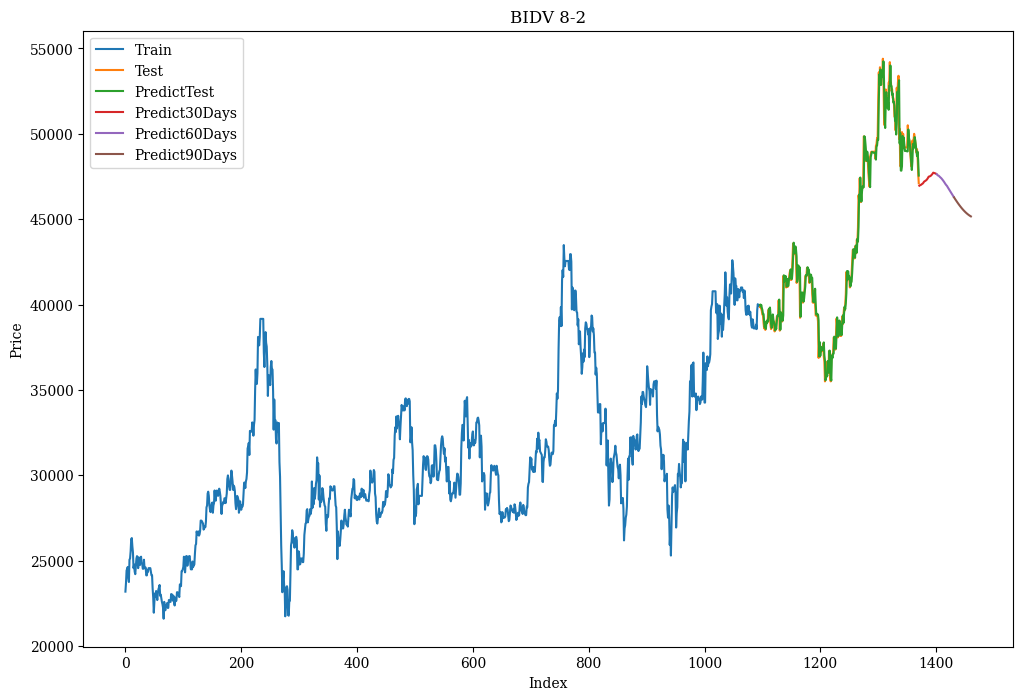

In [43]:
train_data_index = pd.RangeIndex(start=0, stop=train_size, step=1)
test_data_index = pd.RangeIndex(start=train_size, stop=train_size+test_size, step=1)
predict_future_data_index = pd.RangeIndex(start=train_size+test_size, stop=train_size+test_size+len(predict_future), step=1)

print('All result plot')
make_all_result_plot((train_data_index, y_train, test_data_index, y_test, predict_test, predict_future_data_index, predict_future))

Next 90 days plot


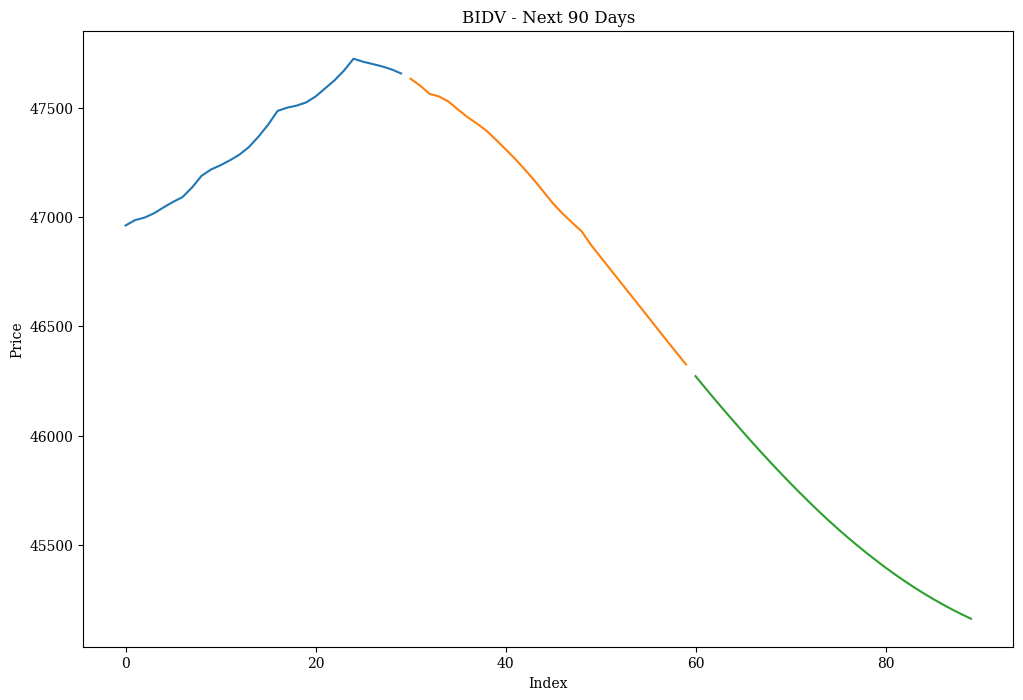

In [44]:
predict_future_data_index = pd.RangeIndex(start=0, stop=len(predict_future), step=1)

print('Next 90 days plot')
make_future_result_plot((predict_future_data_index, predict_future))